Predict TripAdvisor Rating

Данный код готовит данные для предсказания рейтинга ресторана

#### ВНИМАНИЕ, на слабых машинах - не запускать, придется ждать

In [1]:
# Импорт
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime as dtt
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor # инструмент для создания 
                                                    # и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [2]:
# фиксируем RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 44

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# загрузка основных и дополнительных данных
df_train = pd.read_csv('main_task.csv') #тренировочные данные
df_test = pd.read_csv('kaggle_task.csv') #данные для теста
# данные о населении  местоположении городов
df_city = pd.read_csv('worldcitiespop.csv') 

# объединение тестовой и тренировочной выборки
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating,
# мы его должны предсказать, по этому пока просто заполняем 0
df_output = df_test.append(df_train, sort=False).reset_index(drop=True)


/home/olya/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Описание признаков в основном датасете

City: Город
Cuisine Style: Кухня
Ranking: Ранг ресторана относительно других ресторанов в этом городе
Price Range: Цены в ресторане в 3 категориях
Number of Reviews: Количество отзывов
Reviews: 2 последних отзыва и даты этих отзывов
URL_TA: страница ресторана на 'www.tripadvisor.com'
ID_TA: ID ресторана в TripAdvisor
Rating: Рейтинг ресторана

### Описание признаков в дополнительном датасете

Country: страна 
City: название населенного пункта(НП) 
AccentCity: Доп.название НП 
Region: Код региона 
Population: Численность населения 
Latitude, Longitude: GPS-координаты центра НП 


### Визуальный осмотр

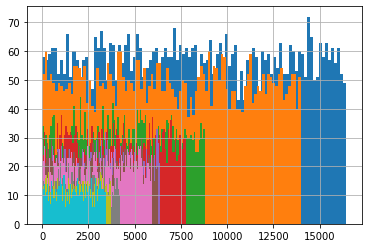

In [5]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()
# Поле Ranking распределено нормально, но зависит от населения,
# поэтому это значение лучше поделить на население города

### Очистка данных

In [6]:
# Удаляем лишние поля из датасетов/или оставляем только нужные
df_city = df_city[['City','Population','Latitude','Longitude']]
df_output.drop(['Restaurant_id','ID_TA','URL_TA'], axis = 1, inplace=True)
df_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   City        object 
 1   Population  float64
 2   Latitude    float64
 3   Longitude   float64
dtypes: float64(3), object(1)
memory usage: 96.9+ MB


### Работа с пустыми значениями NaN/Null

In [7]:
# создаем признак отсутствия данных в количестве отзывов
df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']
                                              ).astype('uint8')
# заполняем общим усреднением
df_output['Number of Reviews'] = (df_output['Number of Reviews'].
                           fillna(df_output['Number of Reviews'].mean()))
# заполняем такой строкой, какая стоит у строк без отзывов
df_output['Reviews'] = df_output['Reviews'].fillna('[[], []]')
# применяем вид кухни - "другая"
df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('Other')
df_output['Price Range'] = df_output['Price Range'].fillna('NoPrice')
# удаляем города, где начеление менее 1000 и те, где нет данных о населении
df_city = df_city.dropna(axis=0)
df_city = df_city[df_city.Population>1000].groupby('City').max().reset_index()
# приведение города к нижнему регистру для будущего join с основным ДС
df_city.City = df_city.City.apply(lambda s: s.lower()) 
# приведение города в основном ДС к нижнему регистру
df_output.City = df_output.City.apply(lambda s: s.lower()) 

### кодирование нечисловых признаков

In [8]:
# города кодируем классически через dummy, создаем бинарные признаки
data1 = pd.get_dummies(df_output.City,prefix='city')
df_output = pd.concat([df_output,data1],axis=1)

# Price Range нельзя кодировать 0 1 2, так как мы не знаем, какой диапазон
# цен подразуменвается под $, $$-$$$ и т.д., и на сколько одни цены выше других
data1 = pd.get_dummies(df_output.City,prefix='Price Range')
df_output = pd.concat([df_output,data1],axis=1)

# Функция деления списка кухонь, возвращает список видов кухонь
def get_list_from_cuisines (s):
    lst = []
    for cuisine_list in s:
        c_list = cuisine_list.split(',')
        for item in c_list:
            item = item.strip()
            if not item in lst:
                lst.append(item)
    return lst

# кодирование списка кухонь
# Разделение с созданием отдельных признаков для кухонь
df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda s:
                        str(s)[1:-1].strip())
df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda s:
                        "'Other'" if s=='a' else s)
df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda s: s.replace("'",""))

# Создание списка кухней 
cuisine_list = get_list_from_cuisines(pd.Series(df_output['Cuisine Style'].unique()))
for cuisine in cuisine_list:
    df_output['cuisine_'+cuisine] = 0
    
# Заполнение признаков
cnt=0
cuisine_styles = pd.Series(df_output['Cuisine Style'].unique())
for style_set in cuisine_styles:
    lst = list(map(lambda s: s.strip(),style_set.split(',')))
    cnt +=1
    for i in lst:
        df_output.loc[df_output['Cuisine Style']==style_set.strip(),
                      'cuisine_'+i] = 1    

# Получение даты отзывов и перевод ее в Timestamp, так как нам нужно число
df_output['tmp_col0'] = None
df_output['tmp_col0'] = df_output['Reviews'].apply(lambda s: 
    [element.strip("'[]") for element in s.split(", ")][-1]) 
df_output['time_review'] = df_output['tmp_col0'].apply (lambda s: 
    dtt.strptime(s,'%m/%d/%Y').timestamp() if len(s)==10 else None)
df_output['time_review'] = df_output['time_review'].fillna(
    df_output['time_review'].mean()) #заполнение средней датой

### Создание новых признаков

In [9]:
# Создание признака количества видов кухонь в ресторяне
df_output['Total Cuisines'] = 0
df_output['Total Cuisines'] = df_output['Cuisine Style'].apply(
    lambda s: 1+s.count(','))

#  длина отзывов
df_output['review_length']= df_output['Reviews'].apply(lambda s: len(s))

# Анализ содержимого текста отзывов
dt1 = pd.DataFrame(columns=['counter'])
for i in range(0,len(df_output)-1):
    rw = df_output['Reviews'].iloc[i].replace('[','').replace(']','').replace(',','').replace("'",'').lower()
    if len(rw)>10:
        lst_rw = rw.split()
        for word in lst_rw[:-2]:
            if len(word)>2:
                if word in dt1.index:
                    dt1.loc[word] += 1
                else:
                    dt1.loc[word] = 1
#берем только частые слова и создаем столбцы c префиксом s для указания 
#наличия слов в отзыве
dt1 = dt1[dt1.counter>100]
for word in dt1.index:
    df_output[word] = 0
# заполняем столбцы
for i in range(0,len(df_output)-1):
    rw = df_output['Reviews'].iloc[i].replace('[','').replace(']',
                                '').replace(',','').replace("'",'').lower()
    if len(rw)>10:
        lst_rw = rw.split()
        for word in lst_rw[:-2]:
            if word in df_output.columns:
                df_output[word].iloc[i] += 1 
                
# Добавление признака актуальности отзывов, количество/давность
dt_review = df_output['time_review'].mean()
now_unix = dtt.now().timestamp()
df_output['rev_act'] = 86400*df_output['Number of Reviews']/((
                now_unix - df_output['time_review']))
   
# Добавление численности населения городов и координат
df_output = df_output.merge(df_city,left_on='City',
                            right_on='City',how='left')
df_output.Population.fillna(df_output.Population.mean(),inplace=True)
df_output.Latitude.fillna(df_output.Latitude.mean(),inplace=True)
df_output.Longitude.fillna(df_output.Longitude.mean(),inplace=True)
# Относительное количество отзывов по городам отзывы/население
df_output['Number of Reviews'] = (df_output['Number of Reviews']/
                                  df_output.Population)

# Корректировка признака Ranking
df_output['Ranking'] = df_output['Ranking']/df_output.Population

/home/olya/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Очистка от нечисловых столбцов

In [10]:
df_output = df_output.drop(columns='Cuisine Style',axis=1)
df_output = df_output.drop(columns='City',axis=1)
df_output = df_output.drop(columns='Price Range',axis=1)
df_output = df_output.drop(columns='Reviews',axis=1)
df_output = df_output.drop(columns='tmp_col0',axis=1)

### Подготовка к тренировке сети

In [11]:
df_output.sample(10)


,Ranking,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,city_amsterdam,city_athens,city_barcelona,city_berlin,city_bratislava,...,wow,sandwiches,long,years,fair,over,rev_act,Population,Latitude,Longitude
17665,0.001160,7.931562e-05,1,5.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.085155,1569315.0,48.200000,16.366667
14053,0.001048,1.886480e-05,1,3.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0.122792,7421228.0,51.514125,-0.093689
44480,0.004054,1.421333e-06,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0.002052,2110694.0,48.866667,2.333333
22149,0.001600,6.064356e-05,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0.090259,2110694.0,48.866667,2.333333
44061,0.001966,1.962666e-06,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.001368,1019022.0,50.833333,4.333333
32835,0.004178,1.337258e-05,1,4.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.015565,1570378.0,41.398371,126.434167
34861,0.000881,2.829720e-06,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0.017454,7421228.0,51.514125,-0.093689
48199,0.003801,4.621806e-05,1,3.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0.010184,346185.0,47.366667,8.550000
10016,0.001548,8.827782e-07,1,4.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.002180,3398362.0,52.516667,13.400000
26556,0.002649,3.595511e-04,1,5.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.085155,346185.0,47.366667,8.550000


In [12]:
#  выделим тестовую часть
train_data = df_output.query('sample == 1').drop(['sample'], axis=1)
test_data = df_output.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [13]:
# Воспользуемся специальной функцие train_test_split для разбивки данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_SEED)

In [14]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 525), (39999, 525), (39999, 524), (31999, 524), (8000, 524))

### Model

In [15]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1,
                              random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [16]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.202485


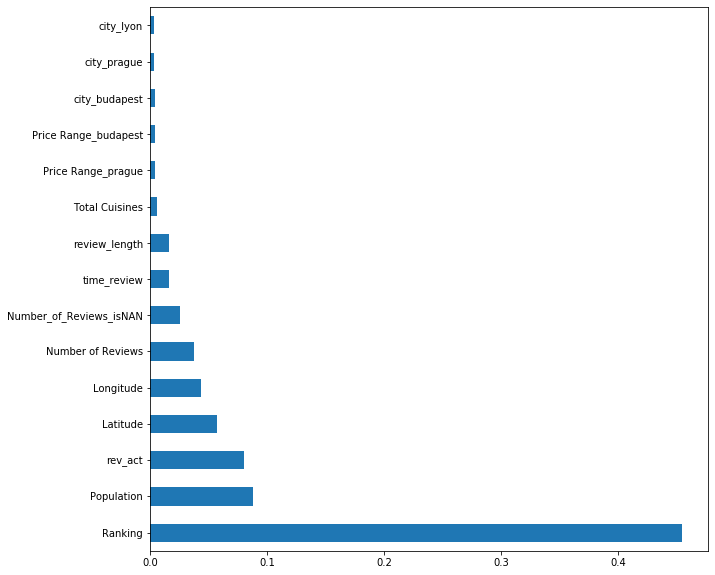

In [17]:
# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')